# Bille sur un plateau rebondissant

In [1]:
import main_code as mc
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from scipy.optimize import curve_fit

## Tracer la vitesse de la bille et du plateau 

In [2]:
# Paramètres de la simulation
w = 100             # Fréquence angulaire du plateau (rad/s)
t_max = 80         # Durée maximale de la simulation (s)
A = 1*10**(-3)     # Amplitude de l'oscillation du plateau (m)
h_i = 75*10**(-3)  # Hauteur initiale de la bille (m)
v_i = 0.0          # Vitesse initiale de la bille (m/s)

# Simulation du mouvement de la bille et du plateau
t_plate, y_plate, t_ball, y_ball, v_ball, id_c = mc.simulate_bouncing_ball_discret(
    w=w, t_max=t_max, A=A, h_i=h_i, v_i=v_i
)

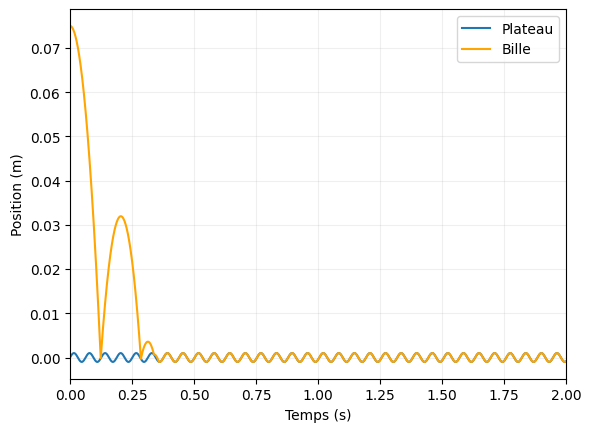

In [3]:
# Tracé des résultats
plt.plot(t_plate, y_plate, label='Plateau')              # Mouvement du plateau
plt.plot(t_ball, y_ball, label='Bille', color='orange')  # Mouvement de la bille

# Personnalisation du graphique
plt.xlim(0, 2)                  # Limite de l'axe des x (temps)
plt.xlabel('Temps (s)')         # Label de l'axe des x
plt.ylabel('Position (m)')      # Label de l'axe des y
plt.grid(alpha=0.2)             # Affichage de la grille avec transparence
plt.legend()                    # Affichage de la légende
plt.show()                      # Affichage du graphique

## Diagramme de bifurcation

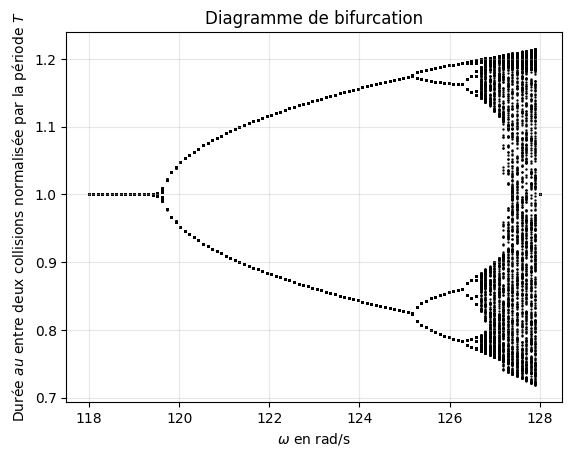

In [128]:
omegas = np.round(np.linspace(118, 128, 100), 2)

for w_ in omegas:
    t_plate, y_plate, t_ball, y_ball, v_ball, id_c = mc.simulate_bouncing_ball_discret(
        w=w_, t_max=30, A=1e-3, h_i=75*10**(-3), v_i=0
    )
    t_collision = t_ball[id_c]
    last_t_collision = t_collision[t_collision>10]
    last_intervals = []
    for i in range(len(last_t_collision)-1):
        last_intervals += [last_t_collision[i+1]-last_t_collision[i]]
    plt.scatter([w_] * len(last_intervals), np.array(last_intervals)*w_/(2*np.pi), c='k', s=0.5)
    plt.title('Diagramme de bifurcation')
    plt.xlabel('$\omega$ en rad/s')
    plt.ylabel('Durée $\tau$ entre deux collisions normalisée par la période $T$')
    plt.grid(alpha=0.3)

## Exposant de Lyapunov

In [5]:
_, _, t, y_ball_1, _, idc_1 = mc.simulate_bouncing_ball_discret(
    w=150, t_max=10, A=1e-3, h_i= 0.075, v_i=0
)

_, _, t, y_ball_2, _, idc_2 = mc.simulate_bouncing_ball_discret(
    w=150, t_max=10, A=1e-3, h_i= 0.075+1e-6, v_i=0
)

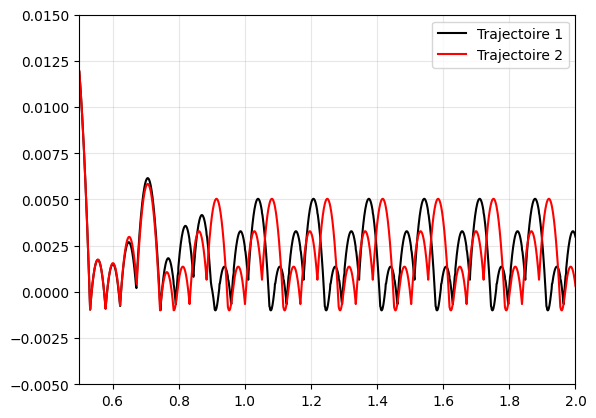

In [6]:
plt.plot(t, y_ball_1, c='k', label='Trajectoire 1')
plt.plot(t, y_ball_2, c='r', label='Trajectoire 2')
plt.xlim(0.5, 2)
plt.ylim(-0.005, 0.015)
plt.legend()
plt.grid(alpha=0.3)

In [7]:
# Concaténation des indices des collisions détectées pour les deux types (ou cas) : idc_1 et idc_2
idc = np.hstack((idc_1, idc_2))

# Suppression des éléments correspondants aux indices de collisions dans le tableau des positions de la bille (avant ou après collision) pour le cas 1
y_ball_1 = np.delete(y_ball_1, np.unique(idc))

# Suppression des mêmes éléments dans le tableau des positions de la bille pour le cas 2
y_ball_2 = np.delete(y_ball_2, np.unique(idc))

# Suppression des instants de temps associés à ces collisions dans le tableau temporel
t = np.delete(t, np.unique(idc))

In [8]:
# Calcul de la divergence entre les trajectoires
delta_y = np.abs(y_ball_1 - y_ball_2)

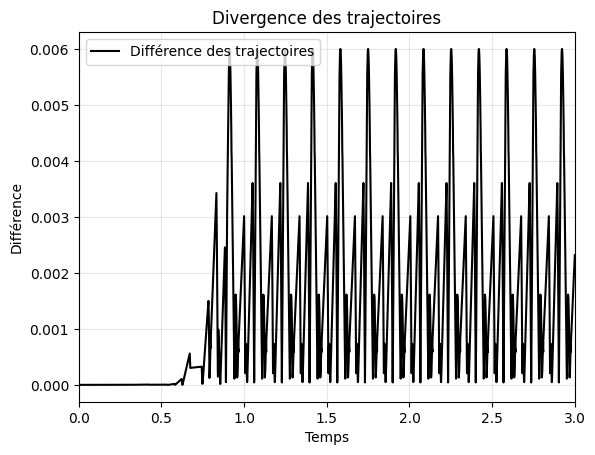

In [9]:
# Tracé de la divergence en fonction du temps
plt.plot(t, delta_y, c='k', label="Différence des trajectoires")
plt.xlabel("Temps")
plt.ylabel("Différence")
plt.title("Divergence des trajectoires")
plt.xlim(0, 3)
plt.legend()
plt.grid(alpha=0.3)

/tmp/ipykernel_1309597/1795795701.py:1: RuntimeWarning: divide by zero encountered in log
  t_log = np.log(t)


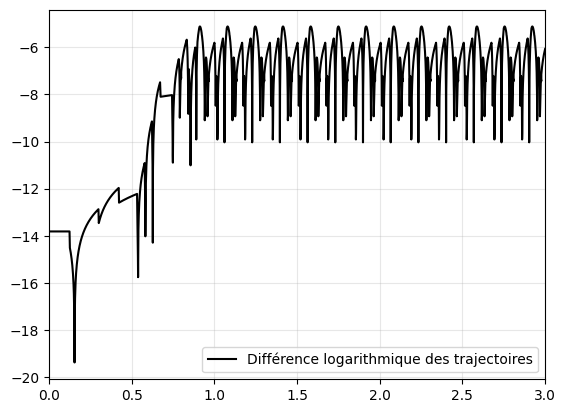

In [10]:
t_log = np.log(t)
delta_y_log = np.log(delta_y + 1e-10) 

plt.plot(t, delta_y_log, c='k', label="Différence logarithmique des trajectoires")
plt.xlim(0, 3)
plt.legend()
plt.grid(alpha=0.3)

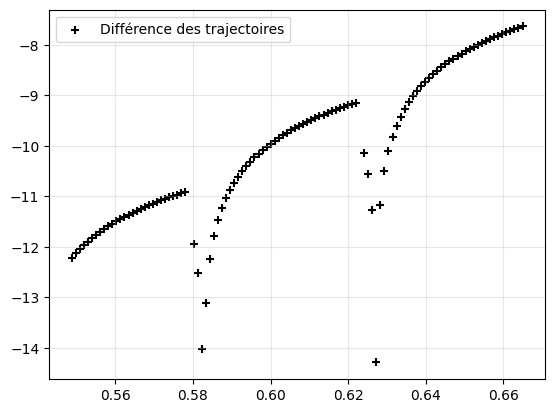

In [11]:
t_filtered = t[520:630]
delta_y_filtered = delta_y_log[520:630]
plt.scatter(t_filtered, delta_y_filtered, marker='+', c='k', label="Différence des trajectoires")
plt.legend()
plt.grid(alpha=0.3)

λ (pente ajustée) = 3.719e+01 s⁻¹


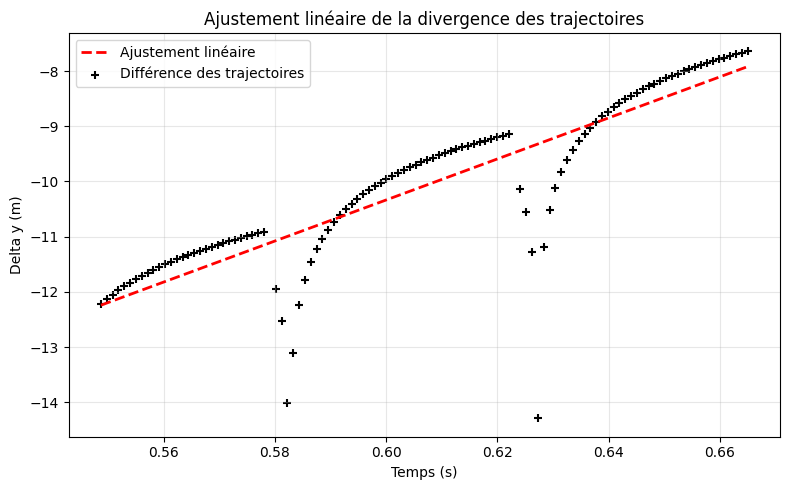

In [13]:
# --- Fonction de modèle linéaire ---
def fit_function(x, a, b):
    """Modèle linéaire : y = a * x + b"""
    return a * x + b

# --- Paramètres initiaux pour l'ajustement ---
guess = [0, 0]  # Estimation initiale de a et b

# --- Ajustement par moindres carrés ---
vals, covar = curve_fit(fit_function, t_filtered, delta_y_filtered, p0=guess)

# --- Génération de la courbe ajustée ---
x_fit = np.linspace(t_filtered[0], t_filtered[-1], 5000)
y_fit = fit_function(x_fit, vals[0], vals[1])

# --- Affichage du paramètre ajusté (pente) ---
# Calcul de l'incertitude sur lambda (écart-type)
lambda_val = vals[0]

# Affichage avec 3 chiffres significatifs
print(f"λ (pente ajustée) = {lambda_val:.3e} s⁻¹")


# --- Tracé du résultat ---
plt.figure(figsize=(8, 5))
plt.plot(x_fit, y_fit, c='r', linestyle='--', lw=2, label='Ajustement linéaire')
plt.scatter(t_filtered, delta_y_filtered, c='k', marker='+', label='Différence des trajectoires')
plt.grid(alpha=0.3)

# --- Personnalisation du graphique ---
plt.title("Ajustement linéaire de la divergence des trajectoires")
plt.xlabel("Temps (s)")
plt.ylabel("Delta y (m)")
plt.legend()
plt.tight_layout()
plt.show()

## Observation de l'attracteur étrange 

In [16]:
t_plate, y_plate, t_ball, y_ball, v_ball, id_c = mc.simulate_bouncing_ball_discret(
    w=2*np.pi*20.43, t_max=120, A=0.001, h_i=0.050001, v_i=0
)

In [17]:
# Initialisation d'une liste pour stocker les temps entre deux chocs successifs
time_between_two_shocks = []

# Récupération des instants où la bille entre en collision avec le plateau
t_collision = t_ball[id_c]

# Sélection des collisions ayant lieu après t > 10 s (on écarte les premiers chocs)
T = t_collision[t_collision > 10]

# Calcul du temps entre chaque paire de collisions successives (T[i+1] - T[i])
for i in range(len(T) - 1):
    time_between_two_shocks += [T[i+1] - T[i]]

# Conversion de la liste en tableau NumPy pour faciliter les traitements
time_between_two_shocks = np.array(time_between_two_shocks)

# Conversion du temps entre chocs en période de l’oscillateur (multiplication par un facteur)
# Ici, le facteur 127.45 / (2π) semble correspondre à une transformation en période ou fréquence.
time_between_two_shocks = time_between_two_shocks * 127.45 / (2 * np.pi)

# Récupération des vitesses de rebond aux instants de collision
v_rebond = v_ball[id_c]

# Récupération des hauteurs de collision correspondantes
y_collision = y_ball[id_c]

# Sélection des vitesses de rebond correspondant aux collisions après t > 10 s (sauf la première)
v = v_rebond[t_collision > 10][1:]

# Sélection des hauteurs de collision correspondant à ces mêmes instants (sauf la première)
y = y_collision[t_collision > 10][1:]

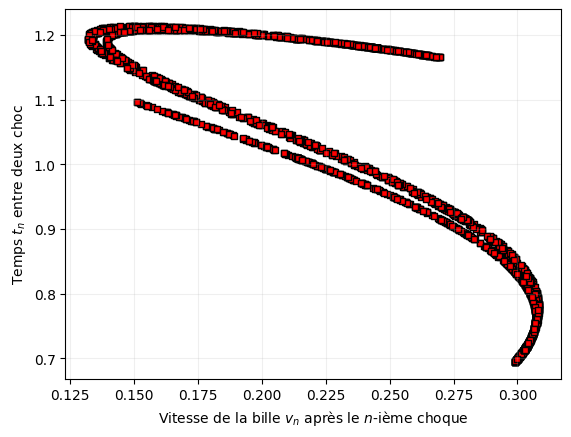

In [18]:
plt.scatter(v, time_between_two_shocks, marker=',', color='r', edgecolors='k', s=18)
plt.xlabel("Vitesse de la bille $v_n$ après le $n$-ième choque")
plt.ylabel("Temps $t_n$ entre deux choc")
plt.grid(alpha=0.2)

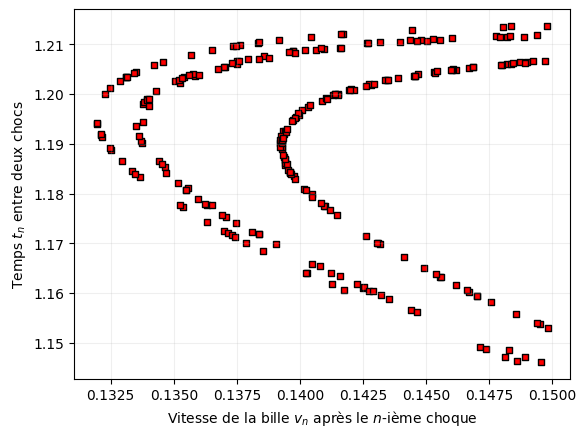

In [19]:
# Définition des limites de zoom
x_min, x_max = 0.125, 0.150  # Intervalle pour v_n
y_min, y_max = 1.1, 1.5  # Intervalle pour τ_n

# Filtrage des données dans ses limites
filtered_v = [v for v, t in zip(v, time_between_two_shocks) if x_min <= v <= x_max and y_min <= t <= y_max]
filtered_t = [t for v, t in zip(v, time_between_two_shocks) if x_min <= v <= x_max and y_min <= t <= y_max]

# Tracer le zoom
plt.scatter(filtered_v, filtered_t, marker=',', color='r', edgecolors='k', s=18)
plt.xlabel("Vitesse de la bille $v_n$ après le $n$-ième choque")
plt.ylabel("Temps $t_n$ entre deux chocs")
plt.grid(alpha=0.2)
plt.show()

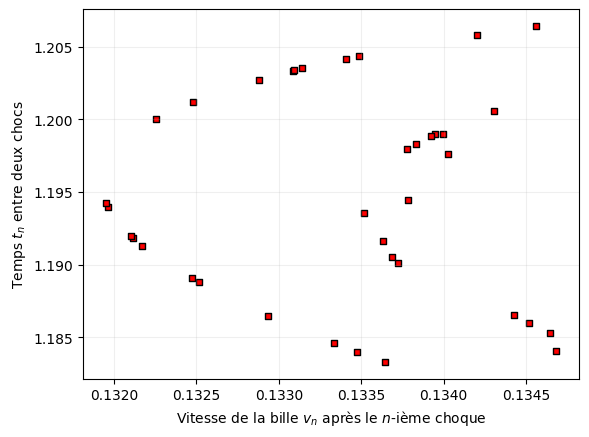

In [20]:
# Définir les limites de zoom
x_min, x_max = 0.1300, 0.1350  # Intervalle pour v_n
y_min, y_max = 1.18, 1.21  # Intervalle pour τ_n

# Filtrer les données dans les limites
filtered_v = [v for v, t in zip(v, time_between_two_shocks) if x_min <= v <= x_max and y_min <= t <= y_max]
filtered_t = [t for v, t in zip(v, time_between_two_shocks) if x_min <= v <= x_max and y_min <= t <= y_max]

# Tracer le zoom
plt.scatter(filtered_v, filtered_t, marker=',', color='r', edgecolors='k', s=18)
plt.xlabel("Vitesse de la bille $v_n$ après le $n$-ième choque")
plt.ylabel("Temps $t_n$ entre deux chocs")
plt.grid(alpha=0.2)
plt.show()

## Explorateur de variable

In [19]:
%whos

Variable                  Type        Data/Info
-----------------------------------------------
T                         ndarray     2247: 2247 elems, type `float64`, 17976 bytes
bisect                    function    <function bisect at 0x7f01cdecb670>
curve_fit                 function    <function curve_fit at 0x7f01cdea6430>
filtered_t                list        n=37
filtered_v                list        n=37
i                         int         2245
id_c                      ndarray     2447: 2447 elems, type `int64`, 19576 bytes
mc                        module      <module 'main_code' from <...>e/Phys num/main_code.py'>
np                        module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
plt                       module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
t_ball                    ndarray     117678: 117678 elems, type `float64`, 941424 bytes (919.359375 kb)
t_collision               ndarray     2447: 2447 elems, type `float64`,